In [1]:
import boto3
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

### data

In [2]:
client = boto3.client('s3')

In [3]:
s3_prefix = 's3://'
bucket = 'sisyphus-general-bucket'
primary_folder = 'AthenaInsights'

In [4]:
# spy_1m_df_loc = f'{s3_prefix}{bucket}/{primary_folder}/data/data_prep/stock_bars_1min.parquet'
spy_1m_df_loc = 's3://sisyphus-general-bucket/AthenaInsights/latest_data/feature_prep/stock_bars_1min_base.parquet'
spy_1m_df = pd.read_parquet(spy_1m_df_loc)
spy_1m_df = spy_1m_df[spy_1m_df.symbol=='SPY']

In [5]:
# Check if the Datetime index is sorted
if spy_1m_df.index.is_monotonic_increasing:
    print("The index is sorted.")
else:
    print("The index is not sorted. Sorting now.")
    spy_1m_df.sort_index(inplace=True)


The index is sorted.


### Variable creation

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def calculate_trend_slope(df, window=20, field='close'):
    """ Calculate the slope of the linear regression line for the last 'window' minutes based on a specified field """
    reg = LinearRegression()
    # Indices for X, specified field values for Y
    x = np.array(range(window)).reshape(-1, 1)
    y = df[field].values.reshape(-1, 1)
    reg.fit(x, y)
    # Slope of the regression line
    return reg.coef_[0][0]

def categorize_points(df, field='close', prev_data_points=20, positive_slope_threshold=0.0, negative_slope_threshold=0.0, positive_rise_threshold=0.0003, negative_drop_threshold=0.0003, positive_future_window=30, negative_future_window=30):
    """ Categorize each minute data point into A, B, or C with dynamic thresholds and fields """
    categories = []
    future_highs = []
    future_lows = []
    slopes = []

    for i in range(len(df)):
        if i < prev_data_points or i > len(df) - max(positive_future_window, negative_future_window):  # Not enough data to categorize
            categories.append('C')  # Consider as undecided for now
            future_highs.append(np.nan)
            future_lows.append(np.nan)
            slopes.append(np.nan)
            continue
        
        # Calculate the trend over the past 20 minutes using the specified field
        past_trend_slope = calculate_trend_slope(df.iloc[i-prev_data_points:i], window=prev_data_points,field=field)
        slopes.append(past_trend_slope)
        
        # Get the current price and future high/low based on the specified field
        current_price = df.iloc[i][field]
        future_high = df.iloc[i+1:i+1+positive_future_window][field].max()
        future_low = df.iloc[i+1:i+1+negative_future_window][field].min()
        future_highs.append(future_high)
        future_lows.append(future_low)
        
        # Calculate thresholds based on current price
        high_threshold = current_price * (1 + positive_rise_threshold)
        low_threshold = current_price * (1 - negative_drop_threshold)
        
        # Determine the category based on the criteria and trend
        if past_trend_slope < negative_slope_threshold and future_high > high_threshold:
            categories.append('A')
        elif past_trend_slope > positive_slope_threshold and future_low < low_threshold:
            categories.append('B')
        else:
            categories.append('C')
    
    return categories, future_highs, future_lows, slopes

def plot_categorization(df, date, field='close', ):
    """ Plot categorization for a given day with dynamic field selection """
    df_day = df.loc[date]
    # categories, future_highs, future_lows = categorize_points(df_day, field=field, **kwargs)
    # df_day['category'] = categories
    # df_day['future_highs'] = future_highs
    # df_day['future_lows'] = future_lows

    
    plt.figure(figsize=(14, 7))
    plt.plot(df_day.index, df_day[field], label=f'{field.capitalize()} Price', color='gray', linewidth=2)
    # plt.plot(df_day.index, df_day['close'], label=f'{field.capitalize()} Price', color='blue', linewidth=1)
    for cat, color in zip(['A', 'B', 'C'], ['green', 'red', 'gray']):
        plt.scatter(df_day[df_day['category'] == cat].index, df_day[df_day['category'] == cat][field], color=color, label=f'Category {cat}', s=20 if cat!='C' else 0)
    plt.legend()
    plt.title(f'Price Categorization on {date}')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{field.capitalize()} Price')
    plt.show()

In [11]:
dates = list(set(spy_1m_df.index.date))

In [98]:
spy_1m_df['category'] = ''
spy_1m_df['future_highs'] = np.nan
spy_1m_df['future_lows'] = np.nan
spy_1m_df['slopes'] = np.nan

field='close_sma_5m'
spy_1m_df[field] = np.where(spy_1m_df[field].isna(), spy_1m_df.close, spy_1m_df[field])

for date in dates:
    # df_day = spy_1m_df[spy_1m_df.us_eastern_date==date]
    df_day = spy_1m_df.loc[date.strftime('%Y-%m-%d')]
    categories, future_highs, future_lows, slopes = categorize_points(df_day, field=field, prev_data_points=11,
                                                              positive_slope_threshold=0.013, negative_slope_threshold=-0.026, 
                                                              positive_rise_threshold=0.0007, negative_drop_threshold=0.0012, 
                                                              positive_future_window=30, negative_future_window=30)
                                                              
    spy_1m_df.loc[date.strftime('%Y-%m-%d'), 'category'] = categories
    spy_1m_df.loc[date.strftime('%Y-%m-%d'), 'future_highs'] = future_highs
    spy_1m_df.loc[date.strftime('%Y-%m-%d'), 'future_lows'] = future_lows
    spy_1m_df.loc[date.strftime('%Y-%m-%d'), 'slopes'] = slopes
    del categories, future_highs, future_lows, df_day


In [99]:
spy_1m_df[['open', 'high', 'low', 'close', 'close_sma_5m', 'category', 'future_highs', 'future_lows', 'slopes']].to_parquet('s3://sisyphus-general-bucket/AthenaInsights/latest_data/dependent_variable/stock_bars_1min.parquet')

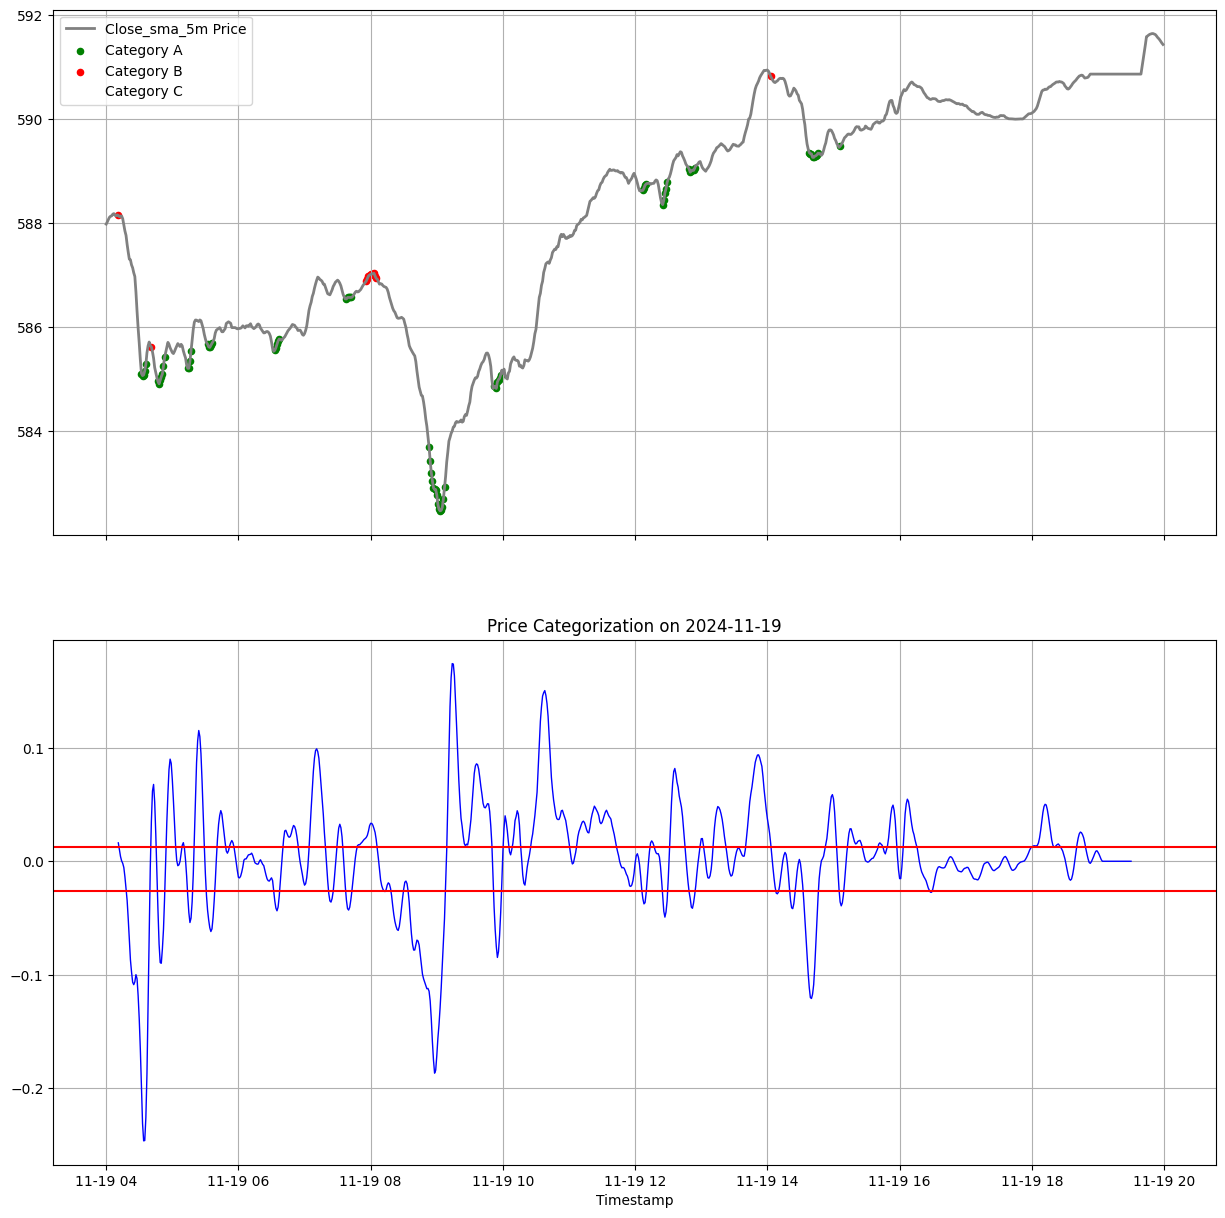

In [100]:


def plot_categorization(df, date, field='close', ):
    """ Plot categorization for a given day with dynamic field selection """
    df_day = df.loc[date]
    
    # plt.figure(figsize=(14, 7))
    # plt.plot(df_day.index, df_day[field], label=f'{field.capitalize()} Price', color='gray', linewidth=2)
    # plt.plot(df_day.index, df_day['slopes'], label=f'{field.capitalize()} Price', color='blue', linewidth=)
    # # plt.plot(df_day.index, df_day['close'], label=f'{field.capitalize()} Price', color='blue', linewidth=1)
    # for cat, color in zip(['A', 'B', 'C'], ['green', 'red', 'gray']):
    #     plt.scatter(df_day[df_day['category'] == cat].index, df_day[df_day['category'] == cat][field], color=color, label=f'Category {cat}', s=20 if cat!='C' else 0)
    # plt.legend()
    # plt.title(f'Price Categorization on {date}')
    # plt.xlabel('Timestamp')
    # plt.ylabel(f'{field.capitalize()} Price')
    # plt.grid()
    # plt.show()


    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 15))
    # fig.figure(figsize=(14, 7))

    ax1.plot(df_day.index, df_day[field], label=f'{field.capitalize()} Price', color='gray', linewidth=2)
    for cat, color in zip(['A', 'B', 'C'], ['green', 'red', 'gray']):
        ax1.scatter(df_day[df_day['category'] == cat].index, df_day[df_day['category'] == cat][field], color=color, label=f'Category {cat}', s=20 if cat!='C' else 0)
    ax1.legend()
    ax1.grid(axis='both', which='both')
    
    ax2.plot(df_day.index, df_day['slopes'], label=f'{field.capitalize()} Price', color='blue', linewidth=1)
    ax2.axhline(y = 0.013, color = 'r', linestyle = '-') 
    ax2.axhline(y = -0.026, color = 'r', linestyle = '-') 
    ax2.grid(axis='both', which='both')

    plt.title(f'Price Categorization on {date}')
    plt.xlabel('Timestamp')
    # ax1.ylabel(f'{field.capitalize()} Price')
    # plt.show()

plot_categorization(spy_1m_df, date='2024-11-19', field=field, )

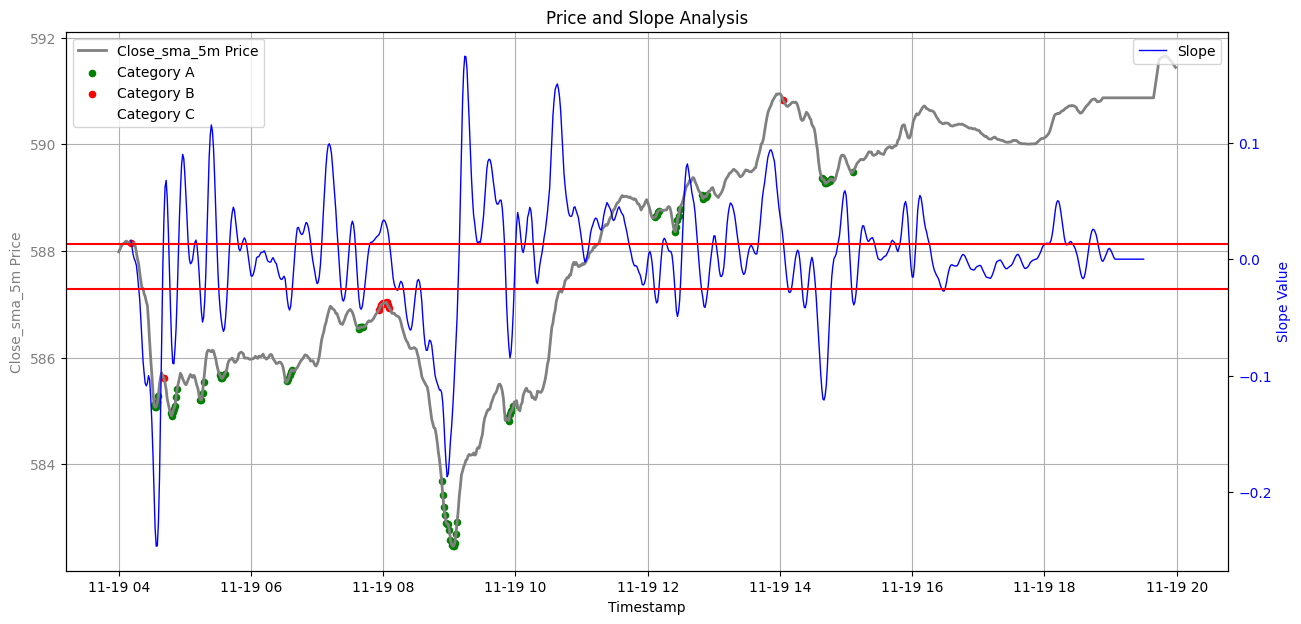

In [101]:
import matplotlib.pyplot as plt
df_day = spy_1m_df.loc['2024-11-19']
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plotting the primary data on the first y-axis
ax1.plot(df_day.index, df_day[field], label=f'{field.capitalize()} Price', color='gray', linewidth=2)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel(f'{field.capitalize()} Price', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.grid(True)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(df_day.index, df_day['slopes'], label='Slope', color='blue', linewidth=1)
ax2.set_ylabel('Slope Value', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Optional: Adding horizontal lines on the second y-axis
ax2.axhline(y = 0.013, color = 'r', linestyle = '-')
ax2.axhline(y = -0.026, color = 'r', linestyle = '-')

# Adding scatter plot for categories on the first y-axis
for cat, color in zip(['A', 'B', 'C'], ['green', 'red', 'gray']):
    ax1.scatter(df_day[df_day['category'] == cat].index, df_day[df_day['category'] == cat][field], color=color, label=f'Category {cat}', s=20 if cat != 'C' else 0)

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(f'Price and Slope Analysis')
plt.show()


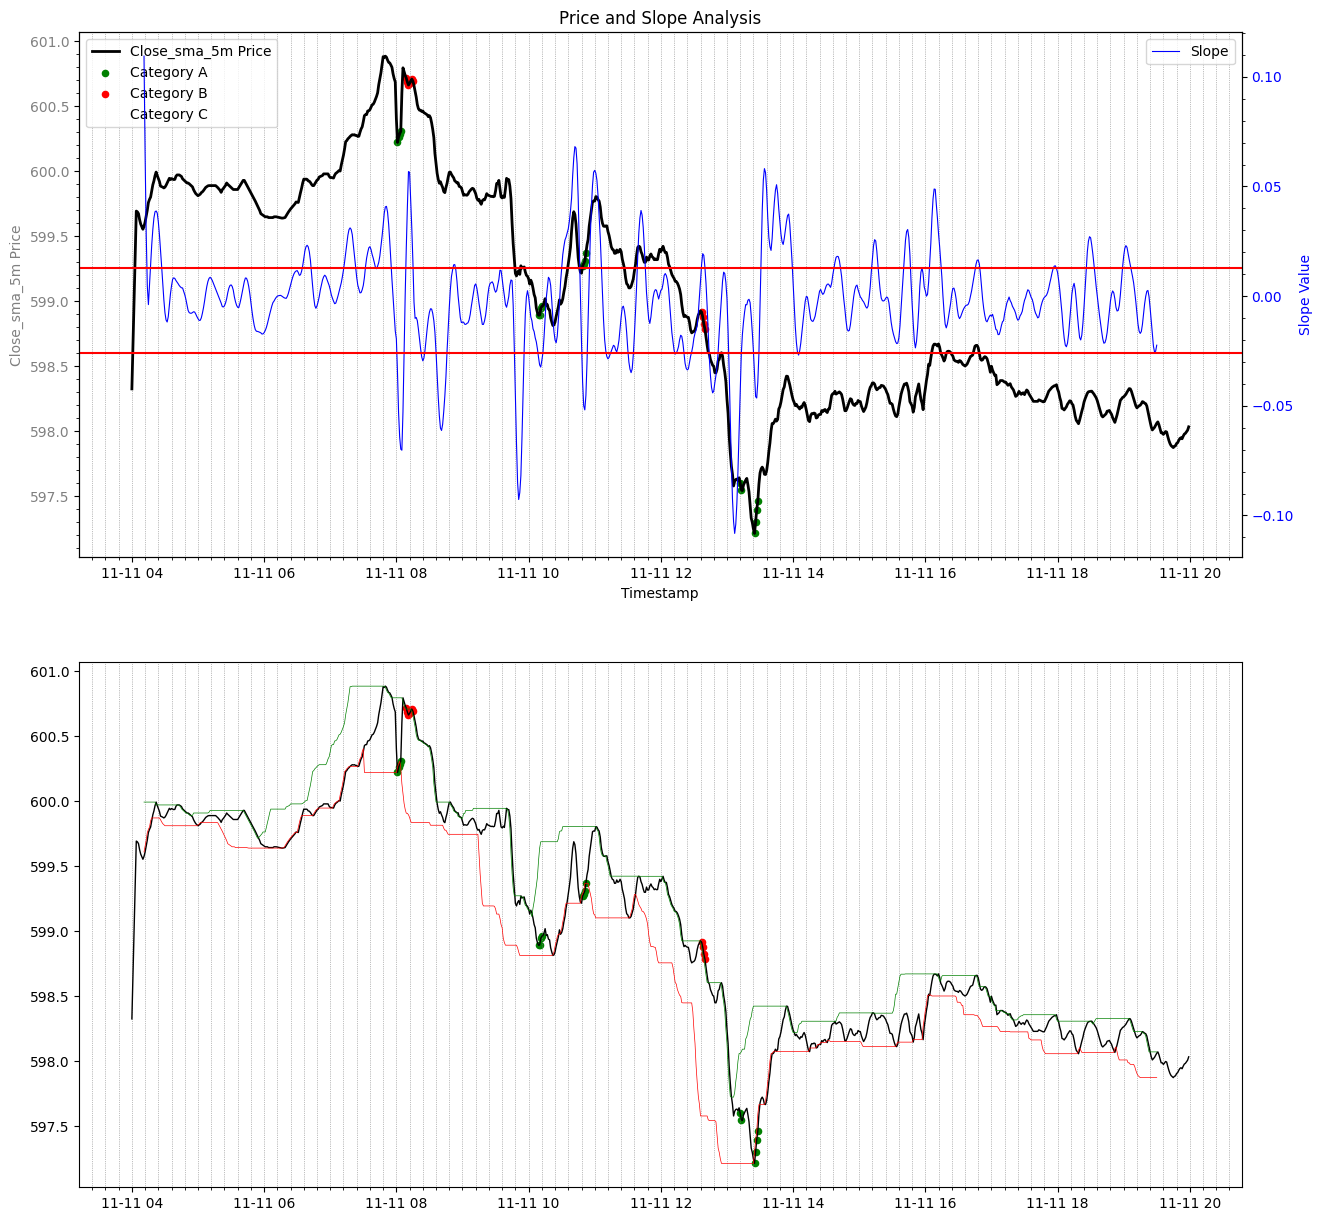

In [102]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

df_day = spy_1m_df.loc['2024-11-11']
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
ax1 = axs[0]
# Plotting the primary data on the first y-axis
ax1.plot(df_day.index, df_day[field], label=f'{field.capitalize()} Price', color='black', linewidth=2)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel(f'{field.capitalize()} Price', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Enable grid for major and minor ticks and set denser minor grid lines
ax1.grid(axis='x', which='major', linestyle=':', linewidth='0.5', color='gray')
ax1.grid(axis='x', which='minor', linestyle=':', linewidth='0.5', color='gray')
ax1.minorticks_on()  # Enable minor ticks
ax1.xaxis.set_minor_locator(AutoMinorLocator(n=10))  # Increase 'n' for even denser grids


axs[1].plot(df_day.index, df_day[field], label=field, color='black', linewidth=1)
axs[1].plot(df_day.index, df_day['future_highs'], label=f'future_highs Price', color='green', linewidth=0.5)
axs[1].plot(df_day.index, df_day['future_lows'], label=f'future_lows Price', color='red', linewidth=0.5)
axs[1].grid(axis='x', which='major', linestyle=':', linewidth='0.5', color='gray')
axs[1].grid(axis='x', which='minor', linestyle=':', linewidth='0.5', color='gray')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(n=10))  # Increase 'n' for even denser grids


# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(df_day.index, df_day['slopes'], label='Slope', color='blue', linewidth=0.8)
ax2.set_ylabel('Slope Value', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Optional: Adding horizontal lines on the second y-axis
ax2.axhline(y = 0.013, color = 'r', linestyle = '-')
ax2.axhline(y = -0.026, color = 'r', linestyle = '-')

# Grid settings for the second y-axis
ax2.grid(axis='x', which='major', linestyle=':', linewidth='0.5', color='gray')
ax2.grid(axis='x', which='minor', linestyle=':', linewidth='0.5', color='gray')
ax2.minorticks_on()  # Enable minor ticks
ax2.xaxis.set_minor_locator(AutoMinorLocator(n=10))  # Increase 'n' for even denser grids

# Adding scatter plot for categories on the first y-axis
for cat, color in zip(['A', 'B', 'C'], ['green', 'red', 'gray']):
    ax1.scatter(df_day[df_day['category'] == cat].index, df_day[df_day['category'] == cat][field], color=color, label=f'Category {cat}', s=20 if cat != 'C' else 0)
    axs[1].scatter(df_day[df_day['category'] == cat].index, df_day[df_day['category'] == cat][field], color=color, label=f'Category {cat}', s=20 if cat != 'C' else 0)

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(f'Price and Slope Analysis')
plt.show()


In [103]:
df_day['future_highs']>df_day[field]*(1+positive_rise_threshold)

us_eastern_timestamp
2024-11-11 04:00:00    False
2024-11-11 04:01:00    False
2024-11-11 04:02:00    False
2024-11-11 04:03:00    False
2024-11-11 04:04:00    False
                       ...  
2024-11-11 19:55:00    False
2024-11-11 19:56:00    False
2024-11-11 19:57:00    False
2024-11-11 19:58:00    False
2024-11-11 19:59:00    False
Length: 960, dtype: bool

In [82]:
field=field
prev_data_points=11
positive_slope_threshold=0.013
negative_slope_threshold=-0.026
positive_rise_threshold=0.0009
negative_drop_threshold=0.0018
positive_future_window=30
negative_future_window=30